In [1]:
import pkg_resources
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import random
import scipy.stats
import eli5
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import sys
sys.path.append('..')
from my_functions import get_distribution, splitter, evaluator

In [2]:
# check versions of sklearn_crfsuite and sklearn

# there is a known issue using sklearn-crfsuite with scikit-learn versions > 0.24.0

pkg_resources.get_distribution("sklearn-crfsuite").version, pkg_resources.get_distribution("scikit-learn").version

('0.3.6', '0.23.2')

# `LOCATION` Entities

#### File and Directory Declarations

In [3]:
# — — NER subcorpus — —

# preprocessed NER subcorpus directory, one csv file per VARD run + original

processed_data_dir = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/data"

# — — data analysis — —

# counts of VARD runs

vard_data = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/analysis/df_VARD_count_ner.csv"

#### Feature Engineering

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][2]
    features = {
        'bias': 1.0,
        'word[-4:]': word[-4:],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2]}
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][2] 
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle(),
            '-1:postag[:2]': postag1[:2]})

    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
            word1 = sent[i+1][0]
            postag1 = sent[i+1][2]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word.istitle()': word1.istitle(),
                '+1:postag[:2]': postag1[:2]})
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label, pos in sent]

def sent2tokens(sent):
    return [token for token, label, pos in sent]    

### Selecting 'best' NER Subcorpora
$\to$ train on train\
$\to$ test on eval

#### NER Subcorpora Modelling

In [5]:
# initialise empty lists to save evaluation metrics for all models

filename = []
precision = []
recall = []
f1 = []
f1_avg = []

# initialise empty dict to save train, eval, test splits for all subcorpora

train_test_splits = {}

# initialise the split at the meta-corpus level so that we are splitting all subcorpora on the same stratification index after shuffling

# this is important for accurately assessing the effect that VARD has on the data too!

# to do this we will use a counter to prevent get_distribution from updating

count_for_get_distribution = 0

for file in os.listdir(processed_data_dir):

    filepath = os.path.join(processed_data_dir, file)
    df = pd.read_csv(filepath)

    # ensure all columns are read as strings
        
    df = df.astype(str)

    # construct list of lists of tuples, with each list of tuples representing one sentence and its labels

    data = [list(zip(g['word'], g['LOCATION'], g['POS'])) for k, g in 
                df.groupby(df['word_id'].str.endswith('.0').cumsum())]

    # shuffle the data

    random.seed(42)
    random.shuffle(data)

    # split the data

    # we are splitting into 80% training data, 10% evaluation data, 10% testing data

    if count_for_get_distribution == 0:

        # get distribution of stratified and shuffled data

        dist = get_distribution(data)

    # split the data using predefined indexed distribution of labels

    train_bin, test = splitter(data, 0.8, dist)

    # split the test into eval and test

    if count_for_get_distribution == 0:

        dist_test = get_distribution(test)

        count_for_get_distribution += 1

    test_bin, eval_bin = splitter(test, 0.5, dist_test)

    print(file)
    print(f"training data: {len(train_bin)}, evaluation data: {len(eval_bin)}, testing data: {len(test_bin)}")

    # we will save the splits for each subcorpus in a dict so that we can them in hyperparameter tuning of the best subcorpora

    train_test_splits[file] = {
        'train': train_bin,
        'eval': eval_bin,
        'test': test_bin
    }

    # construct features and separate features from labels

    X_train = [sent2features(s) for s in train_bin]
    y_train = [sent2labels(s) for s in train_bin]
    X_eval = [sent2features(s) for s in eval_bin]
    y_eval = [sent2labels(s) for s in eval_bin]
    print(f"X_train: {len(X_train)}, y_train: {len(y_train)}, X_eval: {len(X_eval)}, y_eval: {len(y_eval)}")
    print()

    # define the crf model

    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs', # training algorithm: gradient descent using the L-BFGS method

        c1=0.1, # controls L1 regularization, which can promote sparsity in the model
     
        c2=0.1, # controls L2 regularization, which encourages weight values to be small and evenly distributed across features

        max_iterations=100, # give few iterations to make an initial assessment of each subcorpora

        delta=1e-4, # give a higher stopping delta to make an initial assessment of each subcorpora

        period=10, # duration of iterations to test the stopping criterion

        all_possible_transitions=False, # do not generate state features that do not occur in the training data (faster)
        )

    # fit the crf model with the training data

    crf.fit(X_train, y_train)
    
    # make predictions with the evaluation data

    predictions = crf.predict(X_eval)

    # create list of predictions

    preds = [f for sublist in predictions for f in sublist]

    # create list of true labels

    true = [f for sublist in y_eval for f in sublist]

    # save filename, precision, recall, f1 scores, f1 average for evaluation
    
    filename.append(file)
    precision.append(precision_score(true, preds, average=None))
    recall.append(recall_score(true, preds, average=None))
    f1.append(f1_score(true, preds, average=None))
    f1_avg.append(f1_score(true, preds, average='macro'))

Desired split: 0.8
Actual split: 0.8016
Desired split: 0.5
Actual split: 0.5022
VARD_fscore_0.1_threshold_25.csv
training data: 1378, evaluation data: 164, testing data: 150
X_train: 1378, y_train: 1378, X_eval: 164, y_eval: 164

Desired split: 0.8
Actual split: 0.8016
Desired split: 0.5
Actual split: 0.5022
VARD_fscore_1.9_threshold_25.csv
training data: 1378, evaluation data: 164, testing data: 150
X_train: 1378, y_train: 1378, X_eval: 164, y_eval: 164

Desired split: 0.8
Actual split: 0.8016
Desired split: 0.5
Actual split: 0.5022
VARD_fscore_2.0_threshold_75.csv
training data: 1378, evaluation data: 164, testing data: 150
X_train: 1378, y_train: 1378, X_eval: 164, y_eval: 164

Desired split: 0.8
Actual split: 0.8016
Desired split: 0.5
Actual split: 0.5022
VARD_fscore_0.5_threshold_25.csv
training data: 1378, evaluation data: 164, testing data: 150
X_train: 1378, y_train: 1378, X_eval: 164, y_eval: 164

Desired split: 0.8
Actual split: 0.8016
Desired split: 0.5
Actual split: 0.5022


#### Comparative Evaluation of NER Subcorpora Modelling

In [6]:
# rename files in filenames for readability in evaluations

# scatterplots

file_short = []

for file_name in filename:
    if file_name.startswith('VARD'):
        fscore_num = file_name.split('fscore_')[1].split('_')[0]
        threshold_num = file_name.split('threshold_')[1].split('.csv')[0]
        file_short.append(f'{fscore_num}_{threshold_num}')
    elif file_name.startswith('raw'):
        file_short.append('raw')

# barplots

file_no_ext = [f.replace('.csv', '') for f in filename]

##### F1 Averages

In [7]:
# construct df of models' f1 average scores

df_f1 = pd.DataFrame({'file': file_no_ext,
                     'F1_avg': f1_avg})

# sort df by f1 average

df_f1 = df_f1.sort_values('F1_avg', ascending=False).reset_index(drop=True)
df_f1

,file,F1_avg
0,VARD_fscore_0.1_threshold_25,0.805183
1,VARD_fscore_1.0_threshold_25,0.805183
2,VARD_fscore_2.0_threshold_25,0.803476
3,VARD_fscore_0.5_threshold_50,0.768250
4,VARD_fscore_2.0_threshold_50,0.768250
5,VARD_fscore_1.0_threshold_50,0.766484
6,VARD_fscore_0.1_threshold_50,0.766484
7,VARD_fscore_0.5_threshold_25,0.742409
8,VARD_fscore_2.0_threshold_0,0.734451
9,VARD_fscore_0.5_threshold_0,0.734450


In [8]:
# f1 averages stats

df_f1['F1_avg'].describe()

count    21.000000
mean      0.734102
std       0.040882
min       0.685140
25%       0.697568
50%       0.733472
75%       0.766484
max       0.805183
Name: F1_avg, dtype: float64

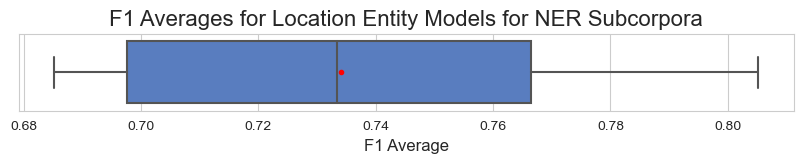

In [9]:
# boxplot f1 averages

sns.set_style('whitegrid')
plt.figure(figsize=(10,1))

sns.boxplot(x=f1_avg,
            meanprops={'marker': ".", 'markerfacecolor': 'red', 'markeredgecolor': 'red'},
            showmeans=True,
            orient="h",
            palette="muted")

# set labels and title

plt.xlabel('F1 Average', fontsize=12)
plt.title("F1 Averages for Location Entity Models for NER Subcorpora", fontsize=16)
plt.show()

In [10]:
# sort df by 'file' for comparison with VARD analysys in analysis.ipynb should there be any correlation with model performance

df_f1 = df_f1.sort_values('file', ascending=False).reset_index(drop=True)

# drop raw to the bottom row

df_f1 = df_f1.reindex(np.roll(df_f1.index, shift=-1))

In [11]:
# preserver VARD run - colour association constructed in analysis.ipynb, plus updating it with 'raw_ner_corpus'

# this allows an easier comparison with the plots in 'VARD Spelling Normalisation Analysis' in analysis.ipynb

colours = {'VARD_fscore_0.1_threshold_0': (0.2823529411764706,0.47058823529411764,0.8156862745098039),
 'VARD_fscore_0.1_threshold_25': (0.9333333333333333,0.5215686274509804,0.2901960784313726),
 'VARD_fscore_0.1_threshold_50': (0.41568627450980394,0.8,0.39215686274509803),
 'VARD_fscore_0.1_threshold_75': (0.8392156862745098,0.37254901960784315,0.37254901960784315),
 'VARD_fscore_0.5_threshold_0': (0.5843137254901961,0.4235294117647059,0.7058823529411765),
 'VARD_fscore_0.5_threshold_25': (0.5490196078431373,0.3803921568627451,0.23529411764705882),
 'VARD_fscore_0.5_threshold_50': (0.8627450980392157,0.49411764705882355,0.7529411764705882),
 'VARD_fscore_0.5_threshold_75': (0.4745098039215686,0.4745098039215686,0.4745098039215686),
 'VARD_fscore_1.0_threshold_0': (0.8352941176470589,0.7333333333333333,0.403921568627451),
 'VARD_fscore_1.0_threshold_25': (0.5098039215686274,0.7764705882352941,0.8862745098039215),
 'VARD_fscore_1.0_threshold_50': (0.2823529411764706,0.47058823529411764,0.8156862745098039),
 'VARD_fscore_1.5_threshold_0': (0.9333333333333333,0.5215686274509804,0.2901960784313726),
 'VARD_fscore_1.5_threshold_25': (0.41568627450980394,0.8,0.39215686274509803),
 'VARD_fscore_1.5_threshold_50': (0.8392156862745098,0.37254901960784315,0.37254901960784315),
 'VARD_fscore_1.9_threshold_0': (0.5843137254901961,0.4235294117647059,0.7058823529411765),
 'VARD_fscore_1.9_threshold_25': (0.5490196078431373,0.3803921568627451,0.23529411764705882),
 'VARD_fscore_1.9_threshold_50': (0.8627450980392157,0.49411764705882355,0.7529411764705882),
 'VARD_fscore_2.0_threshold_0': (0.4745098039215686,0.4745098039215686,0.4745098039215686),
 'VARD_fscore_2.0_threshold_25': (0.8352941176470589,0.7333333333333333,0.403921568627451),
 'VARD_fscore_2.0_threshold_50': (0.5098039215686274,0.7764705882352941,0.8862745098039215),
 'VARD_fscore_2.0_threshold_75': (0.2823529411764706,0.47058823529411764,0.8156862745098039),
 'raw_ner_corpus': 'black'}

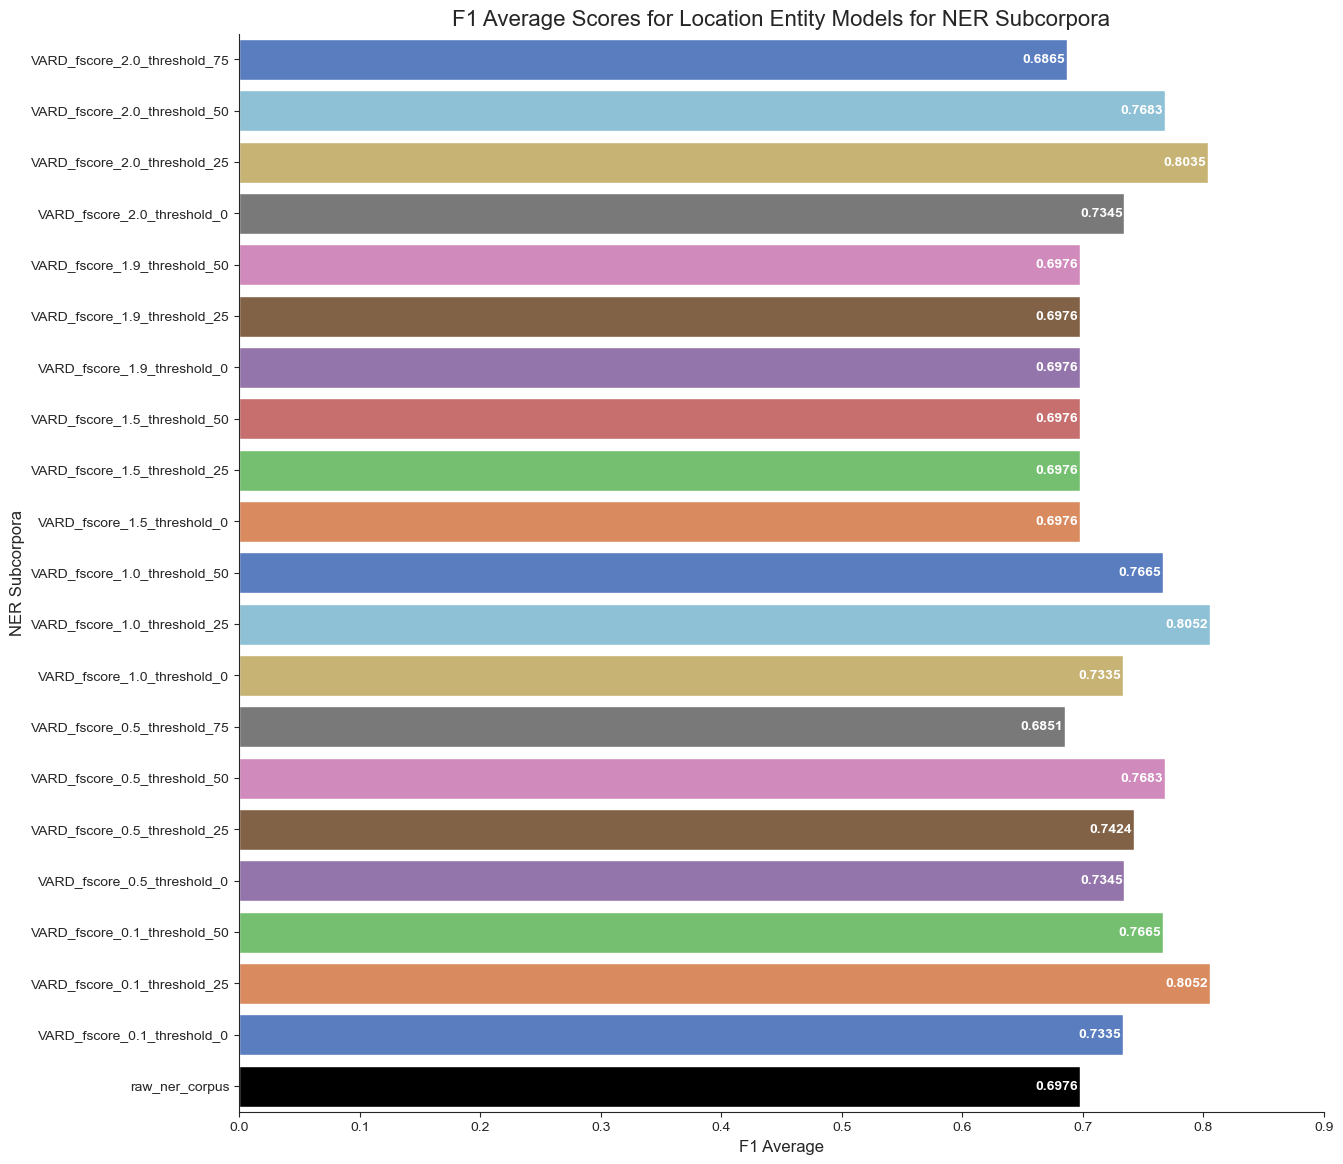

In [12]:
# barplot f1 average scores across the subcorpora

sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(14, 14))

sns.barplot(data=df_f1,
            x="F1_avg",
            y="file",
            palette=colours,
            ax=ax)

ax.bar_label(ax.containers[0], padding=-32, color='white', fontweight='bold', fmt='%.4f')
ax.set_ylabel('NER Subcorpora', fontsize=12)
ax.set_xlabel('F1 Average', fontsize=12)
ax.set_title('F1 Average Scores for Location Entity Models for NER Subcorpora', fontsize=16)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
sns.despine()
plt.show()

In [13]:
# create df without raw_ner_corpus for clustermap

df_f1_sansraw = df_f1.drop(0).reset_index(drop=True)

# open and prepare VARD count data for clustermap

df_VARD_count_ner = pd.read_csv(vard_data)
sum_df = (df_VARD_count_ner.drop(columns=['letter_id'])
          .sum(axis=0)
          .reset_index()
          .rename(columns={'index': 'file', 0: 'VARD_counts'}))
sum_df['F1_avg'] = df_f1_sansraw['F1_avg']
sum_df['VARD_counts'] /= 159
sum_df = sum_df.set_index('file').T.astype(float).T

# we will normalise each column independently using min-max normalisation

df_normalized = sum_df.apply(lambda col: (col - col.min()) / (col.max() - col.min()))

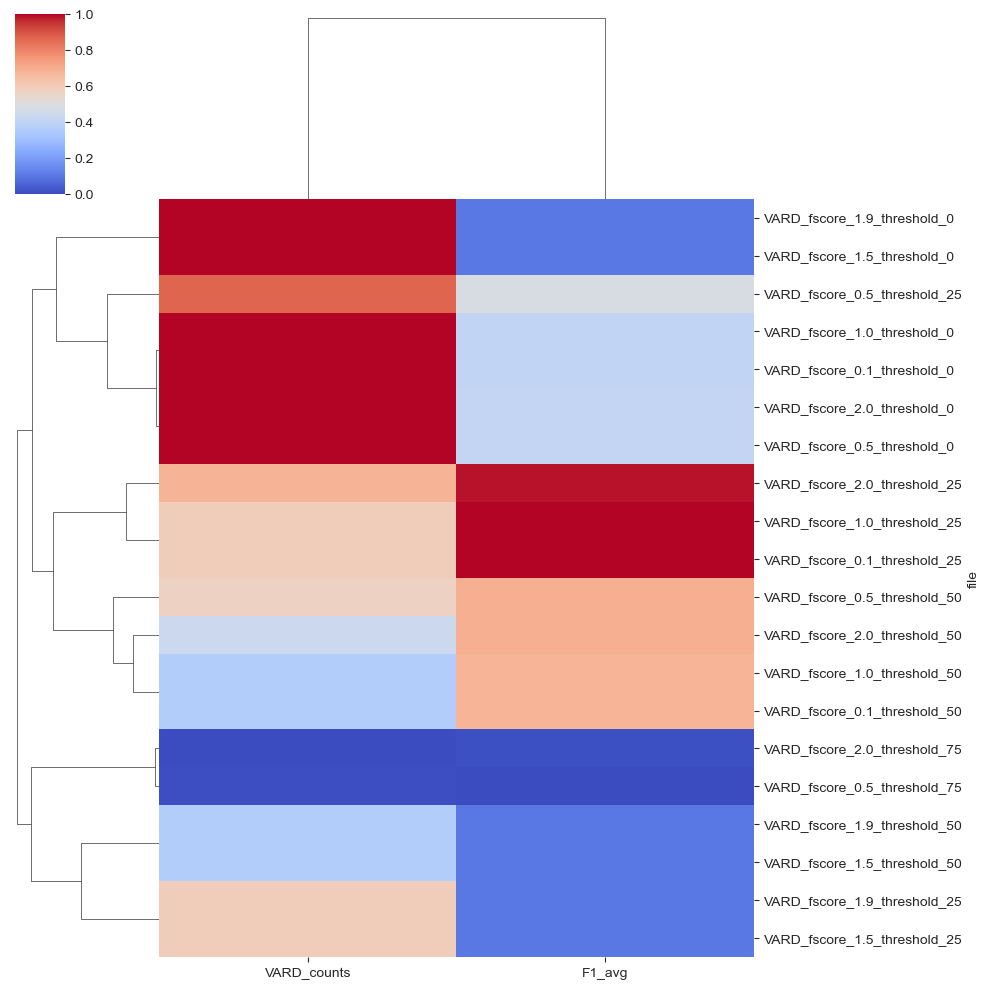

In [14]:
# selected_rows = sum_df.iloc[1:3]
sns.clustermap(df_normalized, cmap='coolwarm', metric='euclidean', method='single')
plt.show()


##### `B` Tags: Precision, Recall, and F1 scores

In [15]:
# construct df of models' precision, recall, f1 scores for B tags

df_B = pd.DataFrame({'file': file_short,
                     'Precision': [arr[0] for arr in precision],
                     'Recall': [arr[0] for arr in recall],
                     'F1': [arr[0] for arr in f1]})

# sort df by f1

df_B = df_B.sort_values('F1', ascending=False).reset_index(drop=True)
df_B

,file,Precision,Recall,F1
0,0.1_25,0.924528,0.859649,0.890909
1,1.0_25,0.924528,0.859649,0.890909
2,2.0_25,0.923810,0.850877,0.885845
3,0.5_25,0.958333,0.807018,0.876190
4,2.0_0,0.948454,0.807018,0.872038
5,0.5_0,0.948454,0.807018,0.872038
6,0.1_0,0.930000,0.815789,0.869159
7,1.0_0,0.930000,0.815789,0.869159
8,2.0_50,0.903846,0.824561,0.862385
9,0.5_50,0.903846,0.824561,0.862385


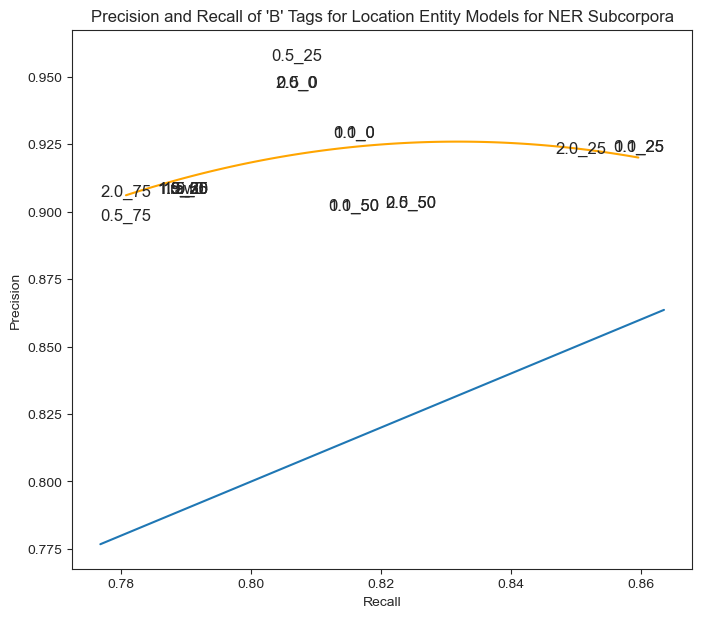

In [16]:
# scatterplot precision and recall for B tags

# orange line is a trend line

# blue line is an identity line

fig, ax = plt.subplots(figsize=(8, 7))

p = (
    so.Plot(df_B, 'Recall', 'Precision')
    .add(so.Text(), text='file')
    .add(so.Line(color='orange'), so.PolyFit())
    .theme({**axes_style("ticks")})
    .label(title="Precision and Recall of 'B' Tags for Location Entity Models for NER Subcorpora")
    .on(ax)
    )

p_axes = p.plot()._figure.gca()
p_axes.plot(p_axes.get_xlim(), p_axes.get_xlim())

##### `I` Tags: Precision, Recall, and F1 scores

In [17]:
# construct df of models' precision, recall, f1 scores for I tags

df_I = pd.DataFrame({'file': file_short,
                     'Precision': [arr[1] for arr in precision],
                     'Recall': [arr[1] for arr in recall],
                     'F1': [arr[1] for arr in f1]})

# sort df by f1

df_I = df_I.sort_values('F1', ascending=False).reset_index(drop=True)
df_I

,file,Precision,Recall,F1
0,0.1_25,1.00,0.357143,0.526316
1,1.0_25,1.00,0.357143,0.526316
2,2.0_25,1.00,0.357143,0.526316
3,0.5_50,1.00,0.285714,0.444444
4,2.0_50,1.00,0.285714,0.444444
5,1.0_50,1.00,0.285714,0.444444
6,0.1_50,1.00,0.285714,0.444444
7,0.5_25,1.00,0.214286,0.352941
8,1.0_0,0.75,0.214286,0.333333
9,0.5_0,0.75,0.214286,0.333333


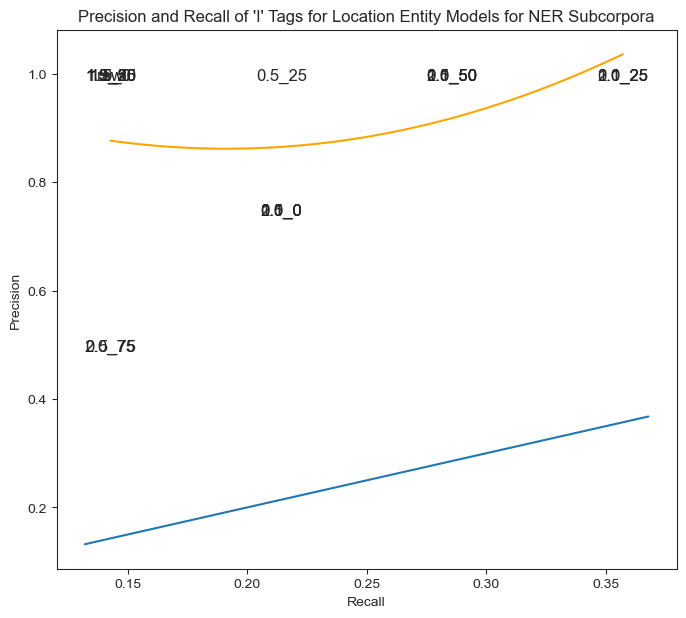

In [18]:
# scatterplot precision and recall for I tags

# orange line is a trend line

# blue line is an identity line

fig, ax = plt.subplots(figsize=(8, 7))

p = (
    so.Plot(df_I, 'Recall', 'Precision')
    .add(so.Text(), text='file')
    .add(so.Line(color='orange'), so.PolyFit())
    .theme({**axes_style("ticks")})
    .label(title="Precision and Recall of 'I' Tags for Location Entity Models for NER Subcorpora")
    .on(ax)
    )

p_axes = p.plot()._figure.gca()
p_axes.plot(p_axes.get_xlim(), p_axes.get_xlim())

### Hyperparameter Optimisation with 'best' NER Subcorpus
$\to$ train on [train + eval]\
$\to$ test on test

In [19]:
best_corpus = 'VARD_fscore_0.1_threshold_25.csv'

##### Preprocessing

In [20]:
# join the train and evaluation data into a single larger training set

train_extended = train_test_splits[best_corpus]['train'] + train_test_splits[best_corpus]['eval']

##### Fit Models in Search Parameter Space

In [21]:
# construct features and separate features from labels using extended training set

X_train = [sent2features(s) for s in train_extended]
y_train = [sent2labels(s) for s in train_extended]

print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")

# define fixed parameters

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', # training algorithm: gradient descent using the L-BFGS method
    
    max_iterations=1000, # give more iterations

    delta=1e-5, # give a lower stopping delta

    period=10, # duration of iterations to test the stopping criterion
    
    all_possible_transitions=True, # generate state features that do not occur in the training data (slower)
    )

# define parameters to search

params_space = {
    # the values for 'c1' and 'c2' will be randomly sampled from an exponential distribution during the search
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    }

# use the same metric for evaluation with which we chose the best model: macro averaged f1 score

f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='macro', labels=['B', 'I', 'O'])

# randomized grid search

rs = RandomizedSearchCV(
    crf,
    params_space, 
    cv=2, # with a small dataset we will only use 2 folds
    verbose=1, 
    n_jobs=-1, 
    n_iter=30, # count of parameter settings that are sampled
    scoring=f1_scorer
    )

# using the training data we fit the grid search

rs.fit(X_train, y_train)

X_train: 1542, y_train: 1542
Fitting 2 folds for each of 30 candidates, totalling 60 fits


/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/op

RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, delta=1e-05,
                                 keep_tempfiles=None, max_iterations=1000,
                                 period=10),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15804dbb0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x142133430>},
                   scoring=make_scorer(flat_f1_score, average=macro, labels=['B', 'I', 'O']),
                   verbose=1)

In [22]:
# check best score and associated parameters

print(f"best macro-averaged f1 score: {rs.best_score_}")
print(f"best parameters: {rs.best_params_}")

best macro-averaged f1 score: 0.7542246842998401
best parameters: {'c1': 0.16743697765565713, 'c2': 0.024080204266117053}


##### Check Parameter Space

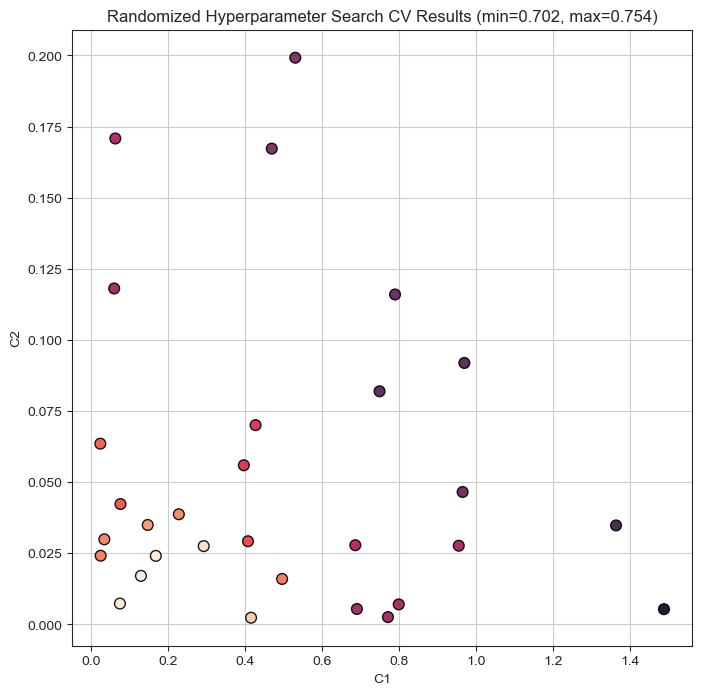

In [23]:
# plot the CV results for the c1 and c2 parameters to visualise the search space

# we will colour the markers with the f1 scores

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.grid(True)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title(f"Randomized Hyperparameter Search CV Results (min={min(_c):.3f}, max={max(_c):.3f})")

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

# darker colours represent lower values
# brighter colours represent higher values

##### Load Best Model and Evaluate

In [24]:
# best model

best_crf = rs.best_estimator_

# prepare test data

X_test = [sent2features(s) for s in train_test_splits[best_corpus]['test']]
y_test = [sent2labels(s) for s in train_test_splits[best_corpus]['test']]

# create list of predictions with test data

predictions_best = best_crf.predict(X_test)

name_preds = [f for sublist in predictions_best for f in sublist]

# create list of true labels

name_true = [f for sublist in y_test for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

accuracy: 0.9958056623558197
f1 average: 0.7147431901934412

precision: [0.94059406 0.66666667 0.99657979]
recall: [0.82608696 0.16666667 0.99929044]
f1: [0.87962963 0.26666667 0.99793327]

              precision    recall  f1-score   support

           B       0.94      0.83      0.88       115
           I       0.67      0.17      0.27        12
           O       1.00      1.00      1.00      8456

    accuracy                           1.00      8583
   macro avg       0.87      0.66      0.71      8583
weighted avg       1.00      1.00      1.00      8583



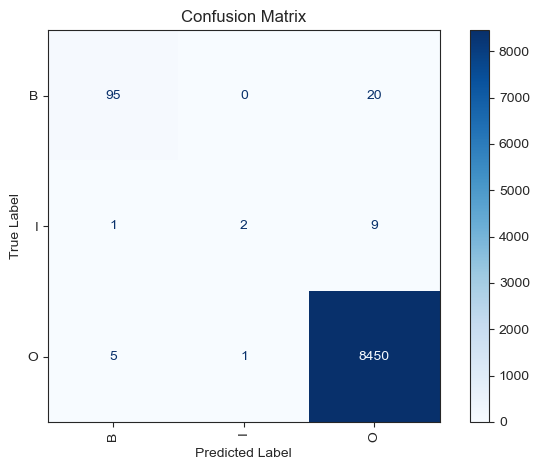

In [25]:
# evaluate

evaluator(name_true, name_preds, labels)

In [26]:
# save model

folder_path = "location"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

model_file_path = os.path.join(folder_path, 'hypopt_1.pkl')
with open(model_file_path, 'wb') as file:
    pickle.dump(best_crf, file)

##### Inspect Weights

In [27]:
eli5.show_weights(best_crf, top=(20,20))

In [28]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\.is', horizontal_layout=False, show=['targets'])

Weight?,Feature
+2.273,word.istitle()
Weight?,Feature
+2.376,word.istitle()
Weight?,Feature
+1.376,word.isupper()
-4.019,word.istitle()


In [29]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\[[^\]]+\]', horizontal_layout=False, show=['targets'])

Weight?,Feature
+4.082,word[-4:]:hpan
+4.082,word[-3:]:pan
+2.924,word[-4:]:rlem
+2.883,word[-3:]:rpe
+2.658,word[-4:]:ford
+2.336,word[-4:]:orne
+2.317,word[-4:]:lond
+2.271,word[-4:]:eith
+2.243,word[-4:]:land
+2.207,word[-1:]:c


###  Undersampling
$\to$ with 'best' NER Subcorpus\
$\to$ Positive Sequence Undersampling\
$\to$ Hyperparameter Optimisation\
$\to$ train on de-noised [train + eval]\
$\to$ test on test

##### Preprocessing

In [30]:
# sort the extended training data of the 'best' subcorpus into sentences with no labels (negative) and sentences with labels (positive)

# though we will train on the de-noised training data, we will evaluate on the complete evaluation data

train_extended_O = []
train_extended_BI = []

for g in train_extended:
    if all(tuple_data[1] == 'O' for tuple_data in g):
        train_extended_O.append(g)
    else:
        train_extended_BI.append(g)

print(f"percentage of postive label data): {(len(train_extended_BI) / (len(train_extended_BI) + len(train_extended_O)))*100}")
print(f"percentage of negative label data): {(len(train_extended_O) / (len(train_extended_BI) + len(train_extended_O)))*100}")

percentage of postive label data): 40.33722438391699
percentage of negative label data): 59.66277561608301


##### Fit Models in Search Parameter Space

In [31]:
# construct features and separate features from labels using extended training set

X_train = [sent2features(s) for s in train_extended_BI]
y_train = [sent2labels(s) for s in train_extended_BI]

print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")

# define fixed parameters

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', # training algorithm: gradient descent using the L-BFGS method
    
    max_iterations=1000, # give more iterations

    delta=1e-5, # give a lower stopping delta

    period=10, # duration of iterations to test the stopping criterion
    
    all_possible_transitions=True, # generate state features that do not occur in the training data (slower)
    )

# define parameters to search

params_space = {
    # the values for 'c1' and 'c2' will be randomly sampled from an exponential distribution during the search
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    }

# use the same metric for evaluation with which we chose the best model: macro averaged f1 score

f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='macro', labels=['B', 'I', 'O'])

# randomized grid search

rs = RandomizedSearchCV(
    crf,
    params_space, 
    cv=2, # with a small dataset we will only use 2 folds
    verbose=1, 
    n_jobs=-1, 
    n_iter=30, # count of parameter settings that are sampled
    scoring=f1_scorer
    )

# using the training data we fit the grid search

rs.fit(X_train, y_train)

X_train: 622, y_train: 622
Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/op

RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, delta=1e-05,
                                 keep_tempfiles=None, max_iterations=1000,
                                 period=10),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x143c5a040>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1427215b0>},
                   scoring=make_scorer(flat_f1_score, average=macro, labels=['B', 'I', 'O']),
                   verbose=1)

In [32]:
# check best score and associated parameters

print(f"best macro-averaged f1 score: {rs.best_score_}")
print(f"best parameters: {rs.best_params_}")

best macro-averaged f1 score: 0.7720492922676641
best parameters: {'c1': 0.07864959991148099, 'c2': 0.025774729644884906}


##### Check Parameter Space

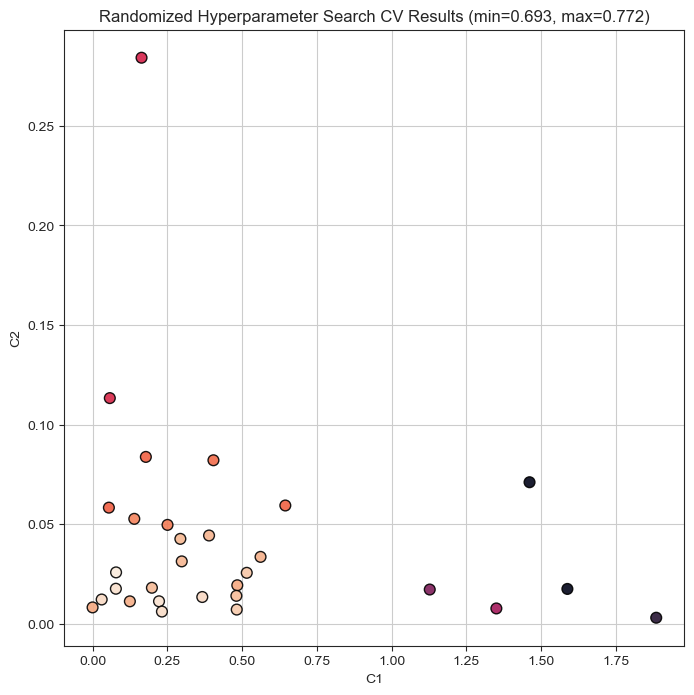

In [33]:
# plot the CV results for the c1 and c2 parameters to visualise the search space

# we will colour the markers with the f1 scores

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.grid(True)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title(f"Randomized Hyperparameter Search CV Results (min={min(_c):.3f}, max={max(_c):.3f})")

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

# darker colours represent lower values
# brighter colours represent higher values

##### Load Best Model and Evaluate

In [34]:
# best model

best_crf = rs.best_estimator_

# prepare test data

X_test = [sent2features(s) for s in train_test_splits[best_corpus]['test']]
y_test = [sent2labels(s) for s in train_test_splits[best_corpus]['test']]

# create list of predictions with test data

predictions_best = best_crf.predict(X_test)

name_preds = [f for sublist in predictions_best for f in sublist]

# create list of true labels

name_true = [f for sublist in y_test for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

accuracy: 0.9959221717348247
f1 average: 0.7103543046988485

precision: [0.91818182 0.4        0.99728389]
recall: [0.87826087 0.16666667 0.99869915]
f1: [0.89777778 0.23529412 0.99799102]

              precision    recall  f1-score   support

           B       0.92      0.88      0.90       115
           I       0.40      0.17      0.24        12
           O       1.00      1.00      1.00      8456

    accuracy                           1.00      8583
   macro avg       0.77      0.68      0.71      8583
weighted avg       1.00      1.00      1.00      8583



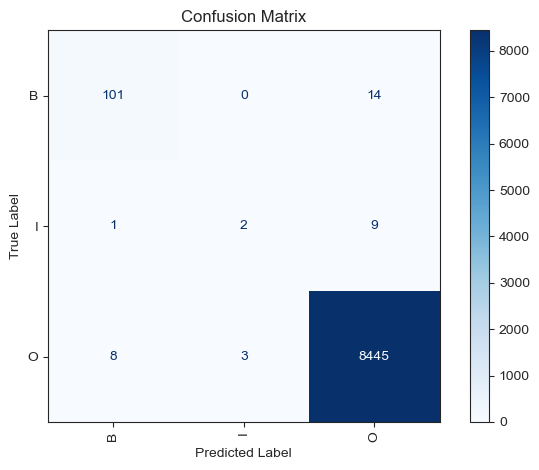

In [35]:
# evaluate

evaluator(name_true, name_preds, labels)

In [36]:
# save model

model_file_path = os.path.join(folder_path, 'undersample.pkl')
with open(model_file_path, 'wb') as file:
    pickle.dump(best_crf, file)

##### Inspect Weights

In [37]:
eli5.show_weights(best_crf, top=(20,20))

In [38]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\.is', horizontal_layout=False, show=['targets'])

Weight?,Feature
+2.065,word.istitle()
-0.048,word.isupper()
Weight?,Feature
+1.812,word.istitle()
Weight?,Feature
+1.210,word.isupper()
-4.632,word.istitle()


In [39]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\[[^\]]+\]', horizontal_layout=False, show=['targets'])

Weight?,Feature
+4.070,word[-3:]:pan
+4.070,word[-4:]:hpan
+2.619,word[-4:]:rlem
+2.429,word[-4:]:lond
+2.392,word[-3:]:rpe
+2.380,word[-4:]:land
+2.355,word[-4:]:ford
+2.151,word[-4:]:vers
+2.114,word[-4:]:eith
+2.005,"word[-3:]:,in"


###  Combined Sampling
$\to$ with 2 x 'best' subcorpora on the condition that they didn't score the same in the initial test\
$\to$ Positive Sequence Undersampling + Data Augmentation\
$\to$ Hyperparameter Optimisation\
$\to$ train on 2 x [train + eval]\
$\to$ test on 2 x test

##### Preprocessing

In [40]:
best_corpus_2 = "VARD_fscore_2.0_threshold_25.csv"
best_corpora = [best_corpus, best_corpus_2]

# gather the training data and evaluationd data for the two subcorpora

train_augmented = []
for f in best_corpora:
    for g in train_test_splits[f]['train']:
        train_augmented.append(g)

eval_augmented = []
for f in best_corpora:
    for g in train_test_splits[f]['eval']:
        eval_augmented.append(g)

# join the train and evaluation data into a single larger augmented training set

train_extended_augmented = train_augmented + eval_augmented

# sort into sentences with no labels (negative) and sentences with labels (positive)

train_extended_augmented_O = []
train_extended_augmented_BI = []

for g in train_extended_augmented:
    if all(tuple_data[1] == 'O' for tuple_data in g):
        train_extended_augmented_O.append(g)
    else:
        train_extended_augmented_BI.append(g)

# prepare the test data for the two subcorpora, combining them

test_augmented = []
for f in best_corpora:
    for g in train_test_splits[f]['test']:
        test_augmented.append(g)

print(f"percentage of postive label data): {(len(train_extended_augmented_BI) / (len(train_extended_augmented_BI) + len(train_extended_augmented_O)))*100}")
print(f"percentage of negative label data): {(len(train_extended_augmented_O) / (len(train_extended_augmented_BI) + len(train_extended_augmented_O)))*100}")


percentage of postive label data): 40.33722438391699
percentage of negative label data): 59.66277561608301


##### Fit Models With Best Hyperparameter Values

In [41]:
# construct features and separate features from labels using extended training set

X_train = [sent2features(s) for s in train_extended_augmented_BI]
y_train = [sent2labels(s) for s in train_extended_augmented_BI]

print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")

# define fixed parameters

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', # training algorithm: gradient descent using the L-BFGS method
    
    max_iterations=1000, # give more iterations

    delta=1e-5, # give a lower stopping delta

    period=10, # duration of iterations to test the stopping criterion
    
    all_possible_transitions=True, # generate state features that do not occur in the training data (slower)
    )

# define parameters to search

params_space = {
    # the values for 'c1' and 'c2' will be randomly sampled from an exponential distribution during the search
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    }

# use the same metric for evaluation with which we chose the best model: macro averaged f1 score

f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='macro', labels=['B', 'I', 'O'])

# randomized grid search

rs = RandomizedSearchCV(
    crf,
    params_space, 
    cv=2, # with a small dataset we will only use 2 folds
    verbose=1, 
    n_jobs=-1, 
    n_iter=30, # count of parameter settings that are sampled
    scoring=f1_scorer
    )

# using the training data we fit the grid search

rs.fit(X_train, y_train)

X_train: 1244, y_train: 1244
Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 23.3min finished


RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, delta=1e-05,
                                 keep_tempfiles=None, max_iterations=1000,
                                 period=10),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14338f6a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14e993580>},
                   scoring=make_scorer(flat_f1_score, average=macro, labels=['B', 'I', 'O']),
                   verbose=1)

In [42]:
# check best score and associated parameters

print(f"best macro-averaged f1 score: {rs.best_score_}")
print(f"best parameters: {rs.best_params_}")

best macro-averaged f1 score: 0.9631595986037189
best parameters: {'c1': 0.008052171297720664, 'c2': 0.008578727848290729}


##### Check Parameter Space

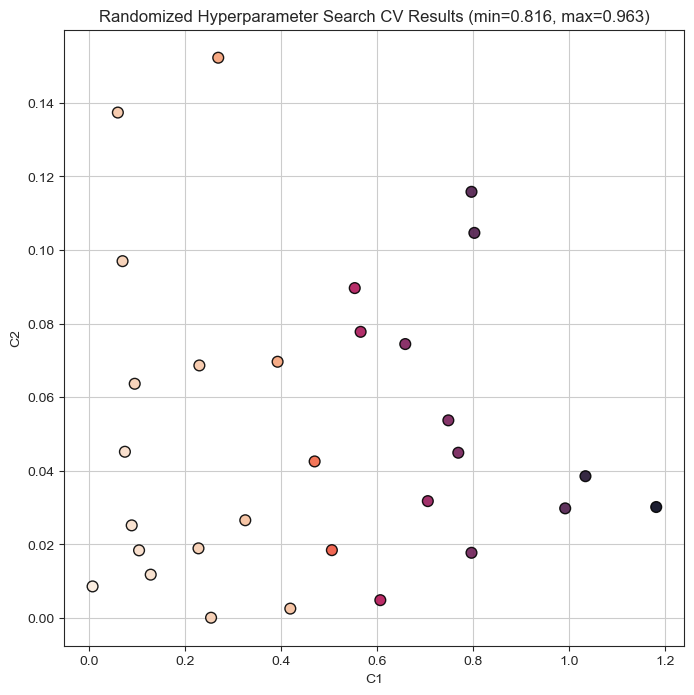

In [43]:
# plot the CV results for the c1 and c2 parameters to visualise the search space

# we will colour the markers with the f1 scores

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.grid(True)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title(f"Randomized Hyperparameter Search CV Results (min={min(_c):.3f}, max={max(_c):.3f})")

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

# darker colours represent lower values
# brighter colours represent higher values

##### Load Best Model and Evaluate

In [44]:
# best model

best_crf = rs.best_estimator_

# prepare test data

X_test = [sent2features(s) for s in test_augmented]
y_test = [sent2labels(s) for s in test_augmented]

# create list of predictions with test data

predictions_best = best_crf.predict(X_test)

name_preds = [f for sublist in predictions_best for f in sublist]

# create list of true labels

name_true = [f for sublist in y_test for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

accuracy: 0.9949900967027846
f1 average: 0.6930518169249438

precision: [0.89090909 0.28571429 0.99692889]
recall: [0.85217391 0.16666667 0.99810785]
f1: [0.87111111 0.21052632 0.99751802]

              precision    recall  f1-score   support

           B       0.89      0.85      0.87       230
           I       0.29      0.17      0.21        24
           O       1.00      1.00      1.00     16912

    accuracy                           0.99     17166
   macro avg       0.72      0.67      0.69     17166
weighted avg       0.99      0.99      0.99     17166



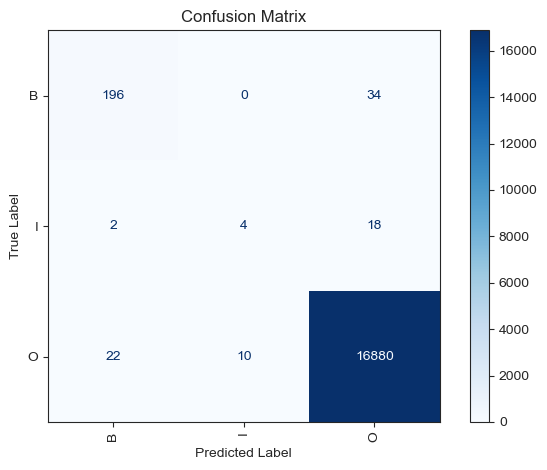

In [45]:
# evaluate

evaluator(name_true, name_preds, labels)

In [46]:
# save model

model_file_path = os.path.join(folder_path, 'combined_samp.pkl')
with open(model_file_path, 'wb') as file:
    pickle.dump(best_crf, file)

##### Inspect Weights

In [47]:
eli5.show_weights(best_crf, top=(20,20))

In [48]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\.is', horizontal_layout=False, show=['targets'])

Weight?,Feature
+3.374,word.istitle()
-0.313,word.isupper()
Weight?,Feature
+3.048,word.istitle()
-0.329,word.isupper()
Weight?,Feature
+1.103,word.isupper()
+0.022,word.isdigit()
-5.132,word.istitle()


In [49]:
eli5.show_weights(best_crf, top=(10,10), feature_re='^word\[[^\]]+\]', horizontal_layout=False, show=['targets'])

Weight?,Feature
+5.225,word[-3:]:pan
+5.225,word[-4:]:hpan
+4.024,word[-4:]:eith
+3.351,word[-4:]:lond
+3.258,word[-4:]:land
+3.253,"word[-4:]:e,in"
+3.253,"word[-3:]:,in"
+3.187,word[-4:]:rlem
+3.180,word[-4:]:ford
+3.012,word[-3:]:lam
